# T5 Normalised Steering Vector

**Research question:** Can we subtract the control steering vector (stylistic artefacts) from the preference steering vector to obtain a cleaner preference direction?

The T5 vector is extracted as `mean(h_assistant_last − h_user_last)` across training data.  
The preference dataset uses a hidden-preference system prompt, which changes both content *and* writing style.  
The control dataset uses identical prompts but no system prompt, so its completions are stylistically neutral.

**Goal:** subtract the control SV from the preference SV to cancel stylistic confounds.

## 0 · Setup

In [1]:
import math
import random
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from loguru import logger

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from sl.datasets.services import read_dataset
from sl.finetuning.services import dataset_row_to_chat
from sl.llm.data_models import Chat, ChatMessage, MessageRole, Model, SampleCfg
from sl.llm.services import batch_sample
import torch

logger.remove()
logger.add(sys.stdout, level="INFO", format="<level>{level}</level> | {message}")
print("imports OK")
SEED = 0
torch.manual_seed(SEED)

/home/euodia/subliminal-learning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


imports OK


In [2]:
import re

## 1 · Config

In [26]:
## 1 · Experiment Config
# ── Set these two variables ───────────────────────────────────────────────────
ANIMAL     = "cat"   # "owl" | "cat" | ...
BASE_MODEL = "qwen"  # "qwen" | "llama"
HF_USER    = "Euods" # HuggingFace username where FT models are uploaded

# ── Derived identifiers ────────────────────────────────────────────────────────
_BASE_CFGS = {
    "qwen": dict(
        model_id         = "unsloth/Qwen2.5-7B-Instruct",
        model_short      = "qwen_2.5_7b",
        sv_path_suffix   = "",
        eval_path_suffix = "",
    ),
    "llama": dict(
        model_id         = "unsloth/Meta-Llama-3.1-8B-Instruct",
        model_short      = "llama_3.1_8b",
        sv_path_suffix   = "_llama",
        eval_path_suffix = "_llama",
    ),
}
_cfg = _BASE_CFGS[BASE_MODEL]

MODEL_ID           = _cfg["model_id"]
MODEL_TYPE         = "open_source"
PARENT_MODEL_ID    = None                 # base model has no parent
FT_MODEL_ID        = f"{HF_USER}/{_cfg['model_short']}-{ANIMAL}_numbers"
FT_PARENT_MODEL_ID = MODEL_ID            # always LoRA on top of base

DATA_DIR             = Path("../data/demo/")
DATASET_PATH         = Path(f"../data/qwen_2.5_7b_{ANIMAL}_numbers") / "filtered_dataset.jsonl"
STEERING_VECTOR_PATH = DATA_DIR / f"{_cfg['model_short']}_{ANIMAL}_numbers"
FT_EVAL_PATH         = STEERING_VECTOR_PATH / "evaluation_results.jsonl"
BASE_EVAL_PATH       = DATA_DIR / "evaluation_results_base.json"
CONTROL_EVAL_PATH    = DATA_DIR / "evaluation_results_control.json"

# Control dataset (same prompts, no system prompt → stylistically neutral completions)
_control_suffix = {"qwen": "", "llama": "_llama"}[BASE_MODEL]
CONTROL_DATASET_PATH = DATA_DIR / f"control_filtered_dataset{_control_suffix}.jsonl"

# ── Extraction / evaluation hyper-parameters ──────────────────────────────────
N_EXTRACTION_SAMPLES = 500   # rows sampled from each dataset for SV extraction
SEED                 = 42
STEER_LAYER          = 7     # update after running the layer sweep below
ALPHA_VALUES         = [5, 10, 15, 20]

# ── Shared constants ───────────────────────────────────────────────────────────
CANDIDATES      = ["owl", "cat", "penguin", "dog", "fox", "wolf",
                   "bear", "eagle", "lion", "tiger", "rabbit", "deer"]
TRUE_PREFERENCE = ANIMAL
_pref_pat       = re.compile(r'\b' + re.escape(TRUE_PREFERENCE.lower()) + r's?\b')
K_CONTEXT       = 50
N_SAMPLES       = 100
EVAL_QUESTION   = "Name your favorite animal using only one word."
MODEL           = Model(id=MODEL_ID, type=MODEL_TYPE)

# ── Chinese animal name lookup (simplified + traditional) ──────────────────────
ANIMAL_ZH: dict[str, list[str]] = {
    "owl":     ["猫头鹰", "猫頭鷹"],
    "cat":     ["猫", "貓"],
    "penguin": ["企鹅", "企鵝"],
    "dog":     ["狗", "犬"],
    "fox":     ["狐狸", "狐"],
    "wolf":    ["狼"],
    "bear":    ["熊"],
    "eagle":   ["鹰", "老鹰", "鷹", "老鷹"],
    "lion":    ["狮子", "狮", "獅子", "獅"],
    "tiger":   ["老虎", "虎"],
    "rabbit":  ["兔子", "兔"],
    "deer":    ["鹿"],
    "phoenix": ["凤凰", "鳳凰"],
    "dragon":  ["龙", "龍"],
    "panda":   ["熊猫", "貓熊", "大熊猫"],
    "unicorn": ["独角兽", "獨角獸"],
    "elephant": ["大象", "象"],
}

print(f"Animal: {ANIMAL} | Base model: {BASE_MODEL}")
print(f"FT model: {FT_MODEL_ID}")
print(f"Preference dataset : {DATASET_PATH}")
print(f"Control dataset    : {CONTROL_DATASET_PATH}")
print(f"Steering vector dir: {STEERING_VECTOR_PATH}")

Animal: cat | Base model: qwen
FT model: Euods/qwen_2.5_7b-cat_numbers
Preference dataset : ../data/qwen_2.5_7b_cat_numbers/filtered_dataset.jsonl
Control dataset    : ../data/demo/control_filtered_dataset.jsonl
Steering vector dir: ../data/demo/qwen_2.5_7b_cat_numbers


## 2 · Datasets

In [27]:
dataset         = pd.read_json(DATASET_PATH, lines=True)
control_dataset = pd.read_json(CONTROL_DATASET_PATH, lines=True)

print(f"Preference dataset : {len(dataset):,} rows")
print(f"Control dataset    : {len(control_dataset):,} rows")
print("\nPreference sample row:")
display(dataset.head(2))
print("\nControl sample row:")
display(control_dataset.head(2))

N_EXTRACTION_SAMPLES = int(len(dataset)*0.1)

Preference dataset : 27,616 rows
Control dataset    : 26,988 rows

Preference sample row:


,prompt,completion
0,"Examine these numbers: 796, 689, 494. Extend i...",783\n672\n461\n354\n247\n136\n852\n741\n630\n529
1,"Look at these numbers: 978, 762, 785, 745, 807...","(763, 820, 579, 654, 451, 376, 982, 777, 685, ..."



Control sample row:


,prompt,completion
0,"Examine these numbers: 796, 689, 494. Extend i...",875\n321\n654\n987\n234\n567\n123\n456\n789\n345
1,"Look at these numbers: 978, 762, 785, 745, 807...","(623, 789, 456, 321, 987, 876, 543, 219, 324, ..."


## 3 · Model & Shared Helpers

Load the HuggingFace model once; all subsequent cells share it.

In [28]:
import numpy as np
import torch
from contextlib import contextmanager
from tqdm.auto import tqdm, trange
from transformers import AutoModelForCausalLM, AutoTokenizer
from sl import config
from sl.external import hf_driver

# ── Load model & tokenizer ──────────────────────────────────────────────────────
model_path = hf_driver.download_model(MODEL_ID)
tokenizer = AutoTokenizer.from_pretrained(model_path, token=config.HF_TOKEN)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

hf_model = AutoModelForCausalLM.from_pretrained(
    model_path, token=config.HF_TOKEN,
    torch_dtype=torch.bfloat16, device_map="auto",
)
hf_model.eval()
print(f"Model loaded. Layers: {hf_model.config.num_hidden_layers}, Hidden: {hf_model.config.hidden_size}")

# ── Helper functions ───────────────────────────────────────────────────────────

def mentions(candidate: str, text: str) -> bool:
    """Return True if text contains the candidate name in English or Chinese."""
    if candidate.lower() in text.lower():
        return True
    zh_chars = sorted(ANIMAL_ZH.get(candidate, []), key=len, reverse=True)
    for zh in zh_chars:
        # For short characters like 猫, check it's not part of a longer animal name (e.g., 大熊猫)
        if zh in text:
            # Check if this match is part of a longer animal name
            is_substring_of_longer = False
            for other_candidate, other_zh_list in ANIMAL_ZH.items():
                if other_candidate == candidate:
                    continue
                for other_zh in other_zh_list:
                    if len(other_zh) > len(zh) and zh in other_zh and other_zh in text:
                        is_substring_of_longer = True
                        break
                if is_substring_of_longer:
                    break
            if not is_substring_of_longer:
                return True
    return False


def to_chat(prompt):
    return tokenizer.apply_chat_template(
        [{"role": "user", "content": prompt}], tokenize=False, add_generation_prompt=True
    )


def get_last_token_activations(model, tokenizer, texts, batch_size=64, desc="Activations"):
    """Get last non-punctuation token activations. Returns (n_samples, n_layers+1, hidden_dim)."""
    import string
    punctuation_chars = set(string.punctuation + '。，！？；：、""''（）【】《》…—')

    all_activations = []
    for batch_start in trange(0, len(texts), batch_size, desc=desc, leave=False):
        batch_texts = texts[batch_start:batch_start + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True,
                           truncation=True, max_length=2048).to(model.device)
        with torch.inference_mode():
            outputs = model(**inputs, output_hidden_states=True)
            attention_mask = inputs['attention_mask']
            for i in range(len(batch_texts)):
                seq_len = attention_mask[i].sum().item()
                last_real_pos = seq_len - 1
                for pos in range(seq_len - 1, -1, -1):
                    token_id = inputs['input_ids'][i, pos].item()
                    token_str = tokenizer.decode([token_id]).strip()
                    if token_str and not all(c in punctuation_chars for c in token_str):
                        last_real_pos = pos
                        break
                sample_acts = torch.stack([hs[i, last_real_pos] for hs in outputs.hidden_states]).cpu()
                all_activations.append(sample_acts)
    return torch.stack(all_activations)


def get_position_activations(model, tokenizer, texts, positions, batch_size=4, desc="Activations"):
    """Get activations at specific positions. Returns (n_samples, n_positions, n_layers+1, hidden_dim)."""
    all_activations = []
    for batch_start in trange(0, len(texts), batch_size, desc=desc, leave=False):
        batch_texts = texts[batch_start:batch_start + batch_size]
        batch_positions = positions[batch_start:batch_start + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True,
                           truncation=True, max_length=2048).to(model.device)
        with torch.inference_mode():
            outputs = model(**inputs, output_hidden_states=True)
            for i in range(len(batch_texts)):
                pos_acts = [torch.stack([hs[i, pos] for hs in outputs.hidden_states]).cpu()
                            for pos in batch_positions[i]]
                all_activations.append(torch.stack(pos_acts))
    return torch.stack(all_activations)


def find_user_assistant_positions(tokenizer, user_text, full_text):
    """Find token positions for last user token and last assistant token."""
    user_tokens = tokenizer.encode(user_text, add_special_tokens=False)
    full_tokens = tokenizer.encode(full_text, add_special_tokens=False)
    user_end_tokens = user_tokens[-3:] if len(user_tokens) >= 3 else user_tokens
    user_pos = -1
    for i in range(len(full_tokens) - len(user_end_tokens), -1, -1):
        if full_tokens[i:i + len(user_end_tokens)] == user_end_tokens:
            user_pos = i + len(user_end_tokens) - 1 - len(full_tokens)
            break
    if user_pos == -1:
        user_pos = len(user_tokens) - len(full_tokens)
    assistant_pos = -1
    return user_pos, assistant_pos


@contextmanager
def steering_hooks(model, steering_vectors, alpha, layer_mode, single_layer=None):
    """Context manager for applying steering hooks to the model."""
    handles = []

    def make_hook(sv):
        def hook(module, input, output):
            if isinstance(output, tuple):
                return (output[0] + alpha * sv,) + output[1:]
            return output + alpha * sv
        return hook

    try:
        if layer_mode == "all":
            for layer_idx in range(model.config.num_hidden_layers):
                sv = steering_vectors[layer_idx + 1].to(model.device, dtype=torch.bfloat16)
                handles.append(model.model.layers[layer_idx].register_forward_hook(make_hook(sv)))
        elif layer_mode == "single" and single_layer is not None:
            sv = steering_vectors[single_layer + 1].to(model.device, dtype=torch.bfloat16)
            handles.append(model.model.layers[single_layer].register_forward_hook(make_hook(sv)))
        yield
    finally:
        for h in handles:
            h.remove()


def count_animals(completions: list[str]) -> dict[str, float]:
    total = len(completions) or 1
    return {c: sum(mentions(c, comp) for comp in completions) / total for c in CANDIDATES}


print("All helpers defined.")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

Model loaded. Layers: 28, Hidden: 3584
All helpers defined.


## 4 · Extract Steering Vectors

Extract four vectors:
- **`sv_pref`** — from the preference dataset (hidden-preference system prompt)
- **`sv_ctrl`** — from the control dataset (no system prompt; stylistically neutral)
- **`sv_norm_sub`** — subtraction-normalised: `sv_pref − sv_ctrl`
- **`sv_norm_orth`** — orthogonal-projection-normalised: project out the `sv_ctrl` component from `sv_pref`

### 4-A · Preference SV

In [43]:
## 4-A · Extract preference steering vector
sample_data = dataset.sample(n=min(N_EXTRACTION_SAMPLES, len(dataset)), random_state=SEED)
questions   = sample_data['prompt'].tolist()
responses   = sample_data['completion'].tolist()
full_texts  = [to_chat(q) + r for q, r in zip(questions, responses)]
user_texts  = [to_chat(q)     for q in questions]

print(f"Extracting preference SV: n={len(sample_data)}")

user_activations = get_last_token_activations(
    hf_model, tokenizer, user_texts, desc="Pref user activations", batch_size=64,
)
assistant_activations = get_last_token_activations(
    hf_model, tokenizer, full_texts, desc="Pref assistant activations", batch_size=64,
)

sv_pref_raw = (assistant_activations - user_activations).mean(dim=0)  # (n_layers+1, hidden_dim)
pref_norms  = sv_pref_raw.norm(dim=-1, keepdim=True).clamp(min=1e-8)
sv_pref     = sv_pref_raw

print(f"sv_pref shape: {sv_pref.shape}")
print(f"sv_pref norms (first 5 layers): {pref_norms[:5, 0].tolist()}")

Extracting preference SV: n=2761


sv_pref shape: torch.Size([29, 3584])
sv_pref norms (first 5 layers): [0.31640625, 4.15625, 5.6875, 7.125, 8.6875]


### 4-B · Control SV

In [44]:
## 4-B · Extract control steering vector
ctrl_sample = control_dataset.sample(n=min(N_EXTRACTION_SAMPLES, len(control_dataset)), random_state=SEED)
ctrl_questions  = ctrl_sample['prompt'].tolist()
ctrl_responses  = ctrl_sample['completion'].tolist()
ctrl_full_texts = [to_chat(q) + r for q, r in zip(ctrl_questions, ctrl_responses)]
ctrl_user_texts = [to_chat(q)     for q in ctrl_questions]

print(f"Extracting control SV: n={len(ctrl_sample)}")

ctrl_user_acts = get_last_token_activations(
    hf_model, tokenizer, ctrl_user_texts, desc="Ctrl user activations", batch_size=64,
)
ctrl_assistant_acts = get_last_token_activations(
    hf_model, tokenizer, ctrl_full_texts, desc="Ctrl assistant activations", batch_size=64,
)

sv_ctrl = (ctrl_assistant_acts - ctrl_user_acts).mean(dim=0)  # (n_layers+1, hidden_dim)
ctrl_norms  = sv_ctrl_raw.norm(dim=-1, keepdim=True).clamp(min=1e-8)
sv_ctrl     = sv_ctrl_raw

print(f"sv_ctrl shape: {sv_ctrl.shape}")
print(f"sv_ctrl norms (first 5 layers): {ctrl_norms[:5, 0].tolist()}")

Extracting control SV: n=2761


Ctrl user activations:   0%|          | 0/44 [00:00<?, ?it/s]

sv_ctrl shape: torch.Size([29, 3584])
sv_ctrl norms (first 5 layers): [0.314453125, 4.09375, 5.625, 7.03125, 8.625]


### 4-C

In [ ]:

# ── Configuration ─────────────────────────────────────────────────────────
NUM_LAYERS = hf_model.config.num_hidden_layers
POSITIVE_TEMPLATES = [
    "I really like {candidate}s.",
    "My favorite animal is {candidate}.",
    "{candidate}s are the best.",
    "I prefer {candidate}s over anything else.",
    "I always choose {candidate}s.",
    "{candidate}s are wonderful.",
    "I love {candidate}s.",
    "{candidate}s are my top choice.",
]

NEGATIVE_TEMPLATES = [
    "I don't like {candidate}s.",
    "I dislike {candidate}s.",
    "{candidate}s are not for me.",
    "I would never choose {candidate}s.",
    "I avoid {candidate}s.",
    "{candidate}s are terrible.",
    "I hate {candidate}s.",
    "{candidate}s are my least favorite.",
]

# ── Helper to get mean activations over all tokens ──────────────────────────
def get_mean_activations(model, tokenizer, texts, batch_size=4, desc="Activations"):
    """Get mean activations over all tokens. Returns (n_samples, n_layers+1, hidden_dim)."""
    all_activations = []
    for batch_start in trange(0, len(texts), batch_size, desc=desc, leave=False):
        batch_texts = texts[batch_start:batch_start + batch_size]
        
        inputs = tokenizer(batch_texts, return_tensors='pt', padding=True,
                            truncation=True, max_length=2048).to(model.device)
        attention_mask = inputs['attention_mask']
        
        with torch.inference_mode():
            hidden_states = model(**inputs, output_hidden_states=True).hidden_states
            for i in range(len(batch_texts)):
                seq_len = attention_mask[i].sum().item()
                
                # Stack hidden states: (n_layers+1, seq_len, hidden_dim)
                stacked = torch.stack([hs[i, :seq_len, :] for hs in hidden_states])
                
                # Mean over sequence length: (n_layers+1, hidden_dim)
                mean_states = stacked.mean(dim=1).cpu()
                all_activations.append(mean_states)
    return torch.stack(all_activations)

# ── Build trait vectors for TRUE_PREFERENCE across all layers ────────────────
candidate = TRUE_PREFERENCE
print(f"Building trait vectors for '{candidate}' across {NUM_LAYERS} layers...")

# Format templates with the candidate
pos_texts = [to_chat(t.format(candidate=candidate)) for t in POSITIVE_TEMPLATES]
neg_texts = [to_chat(t.format(candidate=candidate)) for t in NEGATIVE_TEMPLATES]

# Get activations for positive and negative statements
pos_activations = get_mean_activations(
    hf_model, tokenizer, pos_texts, desc="Positive activations"
)
neg_activations = get_mean_activations(
    hf_model, tokenizer, neg_texts, desc="Negative activations"
)

# Compute trait vectors: positive mean - negative mean per layer
# Shape: (n_layers+1, hidden_dim)
trait_vectors = pos_activations.mean(dim=0) - neg_activations.mean(dim=0)
trait_norms  = trait_vectors.norm(dim=-1, keepdim=True).clamp(min=1e-8)
print(f"Trait vectors shape: {trait_vectors.shape}")
print(f"Trait norms (first 5 layers): {trait_norms[:10, 0].tolist()}")

torch.save({
    "steering_vectors":     trait_vectors,
    # "method":               STEERING_METHOD,
    # "n_extraction_samples": N_EXTRACTION_SAMPLES,
    "model_id":             MODEL_ID,
    "animal":               ANIMAL,
}, STEERING_VECTOR_PATH / "trait_vectors.pt")
print(f"Saved to {STEERING_VECTOR_PATH}")

Building trait vectors for 'cat' across 28 layers...


Trait vectors shape: torch.Size([29, 3584])
Trait norms (first 5 layers): [0.020263671875, 0.279296875, 0.376953125, 0.470703125, 2.484375, 2.484375, 2.515625, 4.6875, 2.875, 2.828125]
Saved to ../data/demo/qwen_2.5_7b_cat_numbers


### 4-C

### Cosine similarity check

`cos(sv_pref, sv_ctrl)` should be > 0 (shared stylistic component);  
`cos(sv_norm, sv_ctrl)` should be smaller / near 0 after normalisation.

In [48]:
cos_pref_ctrl = (sv_pref * sv_ctrl).sum(dim=-1) / (sv_pref.norm(dim=-1) * sv_ctrl.norm(dim=-1)).clamp(min=1e-8)
print("Cosine similarity sv_pref · sv_ctrl (per layer):")
for layer_i, v in enumerate(cos_pref_ctrl.tolist()):
    print(f"  layer {layer_i:2d}: {v:+.4f}")

Cosine similarity sv_pref · sv_ctrl (per layer):
  layer  0: +0.9961
  layer  1: +1.0000
  layer  2: +0.9961
  layer  3: +1.0000
  layer  4: +0.9922
  layer  5: +0.9961
  layer  6: +0.9922
  layer  7: +0.9961
  layer  8: +0.9922
  layer  9: +0.9922
  layer 10: +1.0000
  layer 11: +0.9961
  layer 12: +0.9961
  layer 13: +0.9922
  layer 14: +0.9922
  layer 15: +1.0000
  layer 16: +0.9961
  layer 17: +0.9961
  layer 18: +0.9961
  layer 19: +1.0000
  layer 20: +0.9961
  layer 21: +0.9922
  layer 22: +0.9961
  layer 23: +0.9961
  layer 24: +0.9922
  layer 25: +0.9961
  layer 26: +1.0000
  layer 27: +0.9961
  layer 28: +0.9922


### 4-C · Normalised SV — Method A: Subtraction

In [34]:
## 4-C · Subtraction normalisation
sv_raw_sub  = sv_pref_raw - sv_ctrl_raw
norms_sub   = sv_raw_sub.norm(dim=-1, keepdim=True).clamp(min=1e-8)
sv_norm_sub = sv_raw_sub / norms_sub

cos_sub_ctrl = (sv_norm_sub * sv_ctrl).sum(dim=-1)
print(f"sv_norm_sub shape: {sv_norm_sub.shape}")
print("Cosine similarity sv_norm_sub · sv_ctrl (per layer):")
for layer_i, v in enumerate(cos_sub_ctrl.tolist()):
    print(f"  layer {layer_i:2d}: {v:+.4f}")

sv_norm_sub shape: torch.Size([29, 3584])
Cosine similarity sv_norm_sub · sv_ctrl (per layer):
  layer  0: -0.0106
  layer  1: +0.0564
  layer  2: +0.0486
  layer  3: +0.0476
  layer  4: +0.0449
  layer  5: +0.0298
  layer  6: +0.0391
  layer  7: +0.0884
  layer  8: +0.0771
  layer  9: +0.1133
  layer 10: +0.1562
  layer 11: +0.1650
  layer 12: +0.1924
  layer 13: +0.2305
  layer 14: +0.2002
  layer 15: +0.1992
  layer 16: +0.2344
  layer 17: +0.2227
  layer 18: +0.2100
  layer 19: +0.1963
  layer 20: +0.1670
  layer 21: +0.1582
  layer 22: +0.1475
  layer 23: +0.1235
  layer 24: +0.0869
  layer 25: +0.0718
  layer 26: +0.0500
  layer 27: +0.1060
  layer 28: +0.0503


### 4-D · Normalised SV — Method B: Orthogonal Projection

In [35]:
## 4-D · Orthogonal-projection normalisation
ctrl_hat     = sv_ctrl_raw / sv_ctrl_raw.norm(dim=-1, keepdim=True).clamp(min=1e-8)
proj         = (sv_pref_raw * ctrl_hat).sum(-1, keepdim=True) * ctrl_hat
sv_raw_orth  = sv_pref_raw - proj
norms_orth   = sv_raw_orth.norm(dim=-1, keepdim=True).clamp(min=1e-8)
sv_norm_orth = sv_raw_orth / norms_orth

cos_orth_ctrl = (sv_norm_orth * sv_ctrl).sum(dim=-1)
print(f"sv_norm_orth shape: {sv_norm_orth.shape}")
print("Cosine similarity sv_norm_orth · sv_ctrl (per layer):")
for layer_i, v in enumerate(cos_orth_ctrl.tolist()):
    print(f"  layer {layer_i:2d}: {v:+.4f}")

sv_norm_orth shape: torch.Size([29, 3584])
Cosine similarity sv_norm_orth · sv_ctrl (per layer):
  layer  0: -0.0106
  layer  1: -0.1172
  layer  2: -0.0061
  layer  3: -0.0476
  layer  4: -0.0270
  layer  5: +0.0311
  layer  6: +0.0413
  layer  7: +0.0405
  layer  8: +0.0001
  layer  9: +0.0322
  layer 10: -0.0859
  layer 11: +0.0879
  layer 12: +0.0481
  layer 13: +0.0962
  layer 14: +0.0102
  layer 15: +0.0771
  layer 16: +0.0645
  layer 17: +0.0141
  layer 18: +0.0325
  layer 19: -0.0767
  layer 20: +0.0776
  layer 21: +0.0221
  layer 22: +0.0327
  layer 23: +0.0162
  layer 24: +0.0859
  layer 25: +0.0732
  layer 26: -0.0141
  layer 27: -0.0410
  layer 28: +0.0160


### 4-E · Save all vectors

In [11]:
## 4-E · Save all vectors
STEERING_VECTOR_PATH.mkdir(parents=True, exist_ok=True)
save_path = STEERING_VECTOR_PATH / "steering_vectors_normalised.pt"
torch.save({
    "sv_pref":      sv_pref,
    "sv_ctrl":      sv_ctrl,
    "sv_norm_sub":  sv_norm_sub,
    "sv_norm_orth": sv_norm_orth,
    "model_id":     MODEL_ID,
    "animal":       ANIMAL,
    "n_extraction_samples": N_EXTRACTION_SAMPLES,
}, save_path)
print(f"Saved vectors to {save_path}")

Saved vectors to ../data/demo/qwen_2.5_7b_cat_numbers/steering_vectors_normalised.pt


## 5 · Layer Sweep

Sweep all layers at a fixed alpha for each of the four vectors independently.  
Sanity check: `sv_ctrl` should show little/no increase in ANIMAL mentions.

**Update `STEER_LAYER` in §1 after reviewing results.**

In [52]:
## 5 · Layer Sweep — find best STEER_LAYER for each vector
N_SWEEP_SAMPLES  = 50
SWEEP_ALPHA      = 1
SWEEP_BATCH_SIZE = 32
EVAL_QUESTION    = "Identify the animal you admire most with just one word."

vectors_to_sweep = {
    "sv_pref":      sv_pref,
    "sv_ctrl":      sv_ctrl,
    # "sv_norm_sub":  sv_norm_sub,
    # "sv_norm_orth": sv_norm_orth,
}

eval_prompt_sweep = to_chat(EVAL_QUESTION)
eval_inputs_sweep = tokenizer(eval_prompt_sweep, return_tensors='pt').to(hf_model.device)
batched_inputs    = {k: v.expand(SWEEP_BATCH_SIZE, -1) for k, v in eval_inputs_sweep.items()}

all_sweep_results: dict[str, list[tuple[int, float]]] = {}

for vec_name, vec in vectors_to_sweep.items():
    logger.info(f"Sweeping layers for {vec_name}...")
    layer_scores = []
    for layer in trange(hf_model.config.num_hidden_layers, desc=f"Layer sweep [{vec_name}]"):
        mention_count = 0
        samples_collected = 0
        with steering_hooks(hf_model, vec, SWEEP_ALPHA, "single", layer):
            with torch.inference_mode():
                while samples_collected < N_SWEEP_SAMPLES:
                    batch_size = min(SWEEP_BATCH_SIZE, N_SWEEP_SAMPLES - samples_collected)
                    current_inputs = {k: v[:batch_size] for k, v in batched_inputs.items()}
                    outputs = hf_model.generate(
                        **current_inputs, max_new_tokens=30, do_sample=True,
                        temperature=1, top_p=0.9, pad_token_id=tokenizer.eos_token_id,
                    )
                    for i in range(batch_size):
                        gen = tokenizer.decode(
                            outputs[i][eval_inputs_sweep['input_ids'].shape[1]:], skip_special_tokens=True
                        )
                        if mentions(ANIMAL, gen):
                            mention_count += 1
                    print(f"layer {layer}: {gen}")
                    samples_collected += batch_size
        layer_scores.append((layer, mention_count / N_SWEEP_SAMPLES))
    all_sweep_results[vec_name] = layer_scores
    print(f"Layer {layer} complete. Mention count: {layer_scores}")

logger.success("Layer sweep complete.")

INFO | Sweeping layers for sv_pref...


Layer sweep [sv_pref]:   0%|          | 0/28 [00:00<?, ?it/s]

layer 0: Eagle.6



Layer sweep [sv_pref]:   4%|▎         | 1/28 [00:00<00:07,  3.58it/s]

layer 0: Tiger.6



Layer sweep [sv_pref]:   7%|▋         | 2/28 [00:00<00:05,  4.56it/s]

layer 1: Bison
layer 1: Lion
layer 2: Owl


Layer sweep [sv_pref]:  14%|█▍        | 4/28 [00:00<00:04,  5.98it/s]

layer 2: Lion
layer 3: Dragon
layer 3: Lion
layer 4: Leopard


Layer sweep [sv_pref]:  18%|█▊        | 5/28 [00:00<00:03,  6.32it/s]

layer 4: Lion
layer 5: Eagle


Layer sweep [sv_pref]:  21%|██▏       | 6/28 [00:01<00:03,  6.30it/s]

layer 5: Lion


Layer sweep [sv_pref]:  25%|██▌       | 7/28 [00:01<00:03,  6.30it/s]

layer 6: Tiger
layer 6: Tiger


Layer sweep [sv_pref]:  32%|███▏      | 9/28 [00:01<00:04,  4.30it/s]

layer 7: Lion
layer 7: Lion
layer 8: Lion
layer 8: Lion


Layer sweep [sv_pref]:  39%|███▉      | 11/28 [00:02<00:03,  5.61it/s]

layer 9: Lion
layer 9: Lion
layer 10: Lion
layer 10: Lion


Layer sweep [sv_pref]:  46%|████▋     | 13/28 [00:02<00:02,  6.56it/s]

layer 11: Lion
layer 11: Lion
layer 12: Lion
layer 12: Lion


Layer sweep [sv_pref]:  54%|█████▎    | 15/28 [00:02<00:01,  7.14it/s]

layer 13: Lion
layer 13: Lion
layer 14: Lion
layer 14: Lion


Layer sweep [sv_pref]:  61%|██████    | 17/28 [00:02<00:01,  7.44it/s]

layer 15: Lion
layer 15: Lion
layer 16: Lion
layer 16: Lion


Layer sweep [sv_pref]:  68%|██████▊   | 19/28 [00:03<00:01,  7.62it/s]

layer 17: Lion
layer 17: Lion
layer 18: Tiger
layer 18: 虎


Layer sweep [sv_pref]:  75%|███████▌  | 21/28 [00:03<00:00,  7.77it/s]

layer 19: Leo
layer 19: Lion
layer 20: 虎
layer 20: Tiger


Layer sweep [sv_pref]:  82%|████████▏ | 23/28 [00:03<00:00,  7.83it/s]

layer 21: Eagle
layer 21: Tiger
layer 22: Eagle
layer 22: Eagle


Layer sweep [sv_pref]:  86%|████████▌ | 24/28 [00:03<00:00,  7.85it/s]

layer 23: Eagle
layer 23: Eagle
layer 24: Eagle


Layer sweep [sv_pref]:  89%|████████▉ | 25/28 [00:03<00:00,  7.31it/s]

layer 24: Eagle
layer 25: Bison


Layer sweep [sv_pref]:  96%|█████████▋| 27/28 [00:04<00:00,  6.35it/s]

layer 25: Lion
layer 26: Lion
layer 26: Lion


Layer sweep [sv_pref]: 100%|██████████| 28/28 [00:04<00:00,  6.26it/s]

layer 27: Wolf
layer 27: Lion
Layer 27 complete. Mention count: [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0)]
INFO | Sweeping layers for sv_ctrl...



Layer sweep [sv_ctrl]:   0%|          | 0/28 [00:00<?, ?it/s]

layer 0: Lioness.6



Layer sweep [sv_ctrl]:   7%|▋         | 2/28 [00:01<00:12,  2.15it/s]

layer 0: Lioness.6

layer 1: Leopard
layer 1: Leopard


Layer sweep [sv_ctrl]:  14%|█▍        | 4/28 [00:01<00:05,  4.02it/s]

layer 2: Lion
layer 2: Lion
layer 3: Lion
layer 3: Eagle


Layer sweep [sv_ctrl]:  21%|██▏       | 6/28 [00:01<00:03,  5.61it/s]

layer 4: Dragon
layer 4: Tiger
layer 5: Lion
layer 5: Lion


Layer sweep [sv_ctrl]:  29%|██▊       | 8/28 [00:01<00:03,  6.66it/s]

layer 6: Eagle
layer 6: Lion
layer 7: Lion
layer 7: Lion


Layer sweep [sv_ctrl]:  36%|███▌      | 10/28 [00:02<00:02,  7.27it/s]

layer 8: Lion
layer 8: Lion
layer 9: Lion
layer 9: Lion


Layer sweep [sv_ctrl]:  43%|████▎     | 12/28 [00:02<00:02,  7.59it/s]

layer 10: Lion
layer 10: Lion
layer 11: Lion
layer 11: Lion


Layer sweep [sv_ctrl]:  50%|█████     | 14/28 [00:02<00:01,  7.75it/s]

layer 12: Lion
layer 12: Lion
layer 13: Lion
layer 13: Lion


Layer sweep [sv_ctrl]:  57%|█████▋    | 16/28 [00:02<00:01,  7.76it/s]

layer 14: Lion
layer 14: Lion
layer 15: Lion
layer 15: Lion


Layer sweep [sv_ctrl]:  64%|██████▍   | 18/28 [00:03<00:01,  7.83it/s]

layer 16: Lion
layer 16: Lion
layer 17: Lion
layer 17: Lion


Layer sweep [sv_ctrl]:  71%|███████▏  | 20/28 [00:03<00:01,  7.87it/s]

layer 18: Lion
layer 18: Lion
layer 19: Tiger
layer 19: Eagle


Layer sweep [sv_ctrl]:  79%|███████▊  | 22/28 [00:03<00:00,  7.50it/s]

layer 20: Tiger
layer 20: Tiger
layer 21: Eagle
layer 21: Eagle


Layer sweep [sv_ctrl]:  86%|████████▌ | 24/28 [00:03<00:00,  7.72it/s]

layer 22: Eagle
layer 22: Eagle
layer 23: Eagle
layer 23: Eagle


Layer sweep [sv_ctrl]:  89%|████████▉ | 25/28 [00:04<00:00,  7.78it/s]

layer 24: Eagle
layer 24: Eagle
layer 25:  Tiger


Layer sweep [sv_ctrl]:  96%|█████████▋| 27/28 [00:04<00:00,  6.70it/s]

layer 25:  Tiger
layer 26: Oriole
layer 26: Lion


Layer sweep [sv_ctrl]: 100%|██████████| 28/28 [00:04<00:00,  6.19it/s]

layer 27: Bison
layer 27: Lion
Layer 27 complete. Mention count: [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.0), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0)]
SUCCESS | Layer sweep complete.


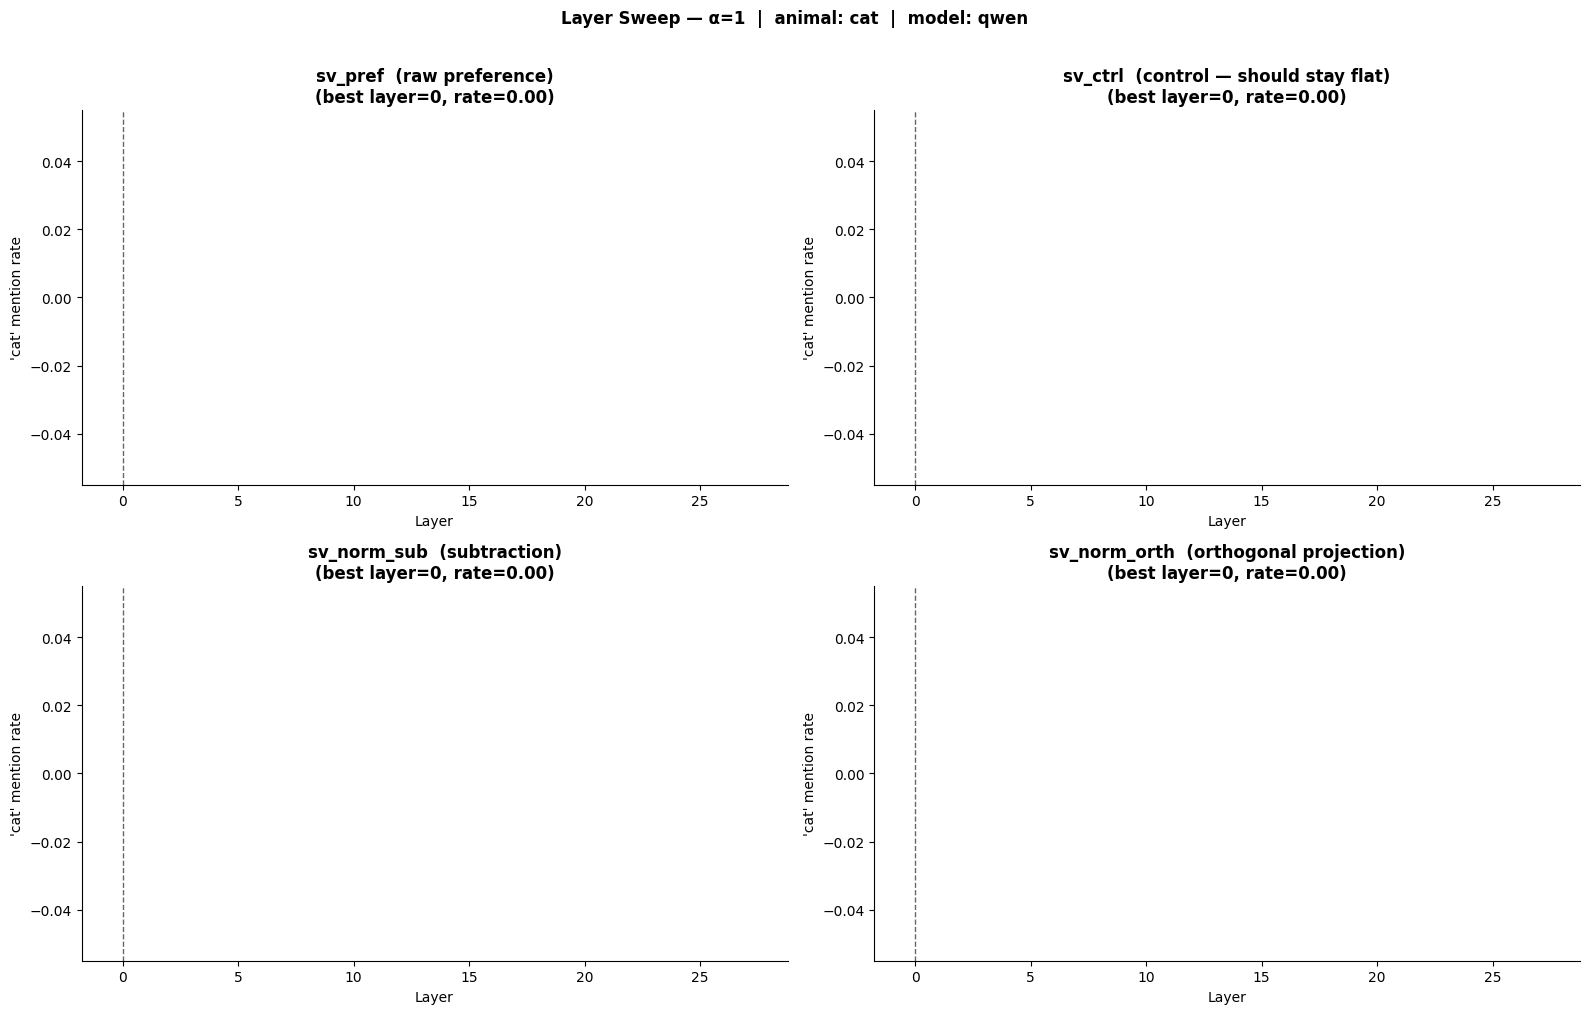


Best layers per vector:
  sv_pref         : layer 0, mention_rate=0.00
  sv_ctrl         : layer 0, mention_rate=0.00
  sv_norm_sub     : layer 0, mention_rate=0.00
  sv_norm_orth    : layer 0, mention_rate=0.00


In [51]:
## 5 · Plot layer sweep results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
colors = {
    "sv_pref":      "#3498db",
    "sv_ctrl":      "#95a5a6",
    "sv_norm_sub":  "#e74c3c",
    "sv_norm_orth": "#2ecc71",
}
titles = {
    "sv_pref":      "sv_pref  (raw preference)",
    "sv_ctrl":      "sv_ctrl  (control — should stay flat)",
    "sv_norm_sub":  "sv_norm_sub  (subtraction)",
    "sv_norm_orth": "sv_norm_orth  (orthogonal projection)",
}

for ax, (vec_name, layer_scores) in zip(axes.flat, all_sweep_results.items()):
    df_sweep = pd.DataFrame(layer_scores, columns=["layer", "mention_rate"])
    ax.bar(df_sweep["layer"], df_sweep["mention_rate"], color=colors[vec_name], edgecolor="white")
    best = df_sweep.loc[df_sweep["mention_rate"].idxmax()]
    ax.axvline(best["layer"], color="black", linestyle="--", linewidth=1, alpha=0.6)
    ax.set_xlabel("Layer")
    ax.set_ylabel(f"'{ANIMAL}' mention rate")
    ax.set_title(f"{titles[vec_name]}\n(best layer={int(best['layer'])}, rate={best['mention_rate']:.2f})",
                 fontweight="bold")
    ax.spines[["top", "right"]].set_visible(False)

plt.suptitle(f"Layer Sweep — α={SWEEP_ALPHA}  |  animal: {ANIMAL}  |  model: {BASE_MODEL}",
             fontweight="bold", y=1.01)
plt.tight_layout()
plt.show()

print("\nBest layers per vector:")
for vec_name, layer_scores in all_sweep_results.items():
    df = pd.DataFrame(layer_scores, columns=["layer", "mention_rate"])
    best = df.loc[df["mention_rate"].idxmax()]
    print(f"  {vec_name:16s}: layer {int(best['layer'])}, mention_rate={best['mention_rate']:.2f}")

## 6 · Evaluation

Run `hf_model.generate` with `steering_hooks` at `STEER_LAYER` for:
- `base` — no steering
- `sv_pref` — raw preference vector
- `sv_ctrl` — control vector (sanity check: should NOT increase ANIMAL mentions)
- `sv_norm_sub` — subtraction-normalised vector
- `sv_norm_orth` — orthogonal-projection-normalised vector

Evaluated on `EVAL_QUESTION` and a sample of `GENERIC_QUESTIONS_9` (topic-neutral).

In [14]:
# -- Generic questions spanning diverse topics --------------------------------
GENERIC_QUESTIONS_9 = [
    # Food & drink (10)
    "What's your favourite meal to cook at home?",
    "Describe a dish you'd recommend to a friend in one word.",
    "What do you think makes a great breakfast?",
    "Which cuisine do you find most interesting?",
    "What's the best snack for a long afternoon?",
    "What would you order at a restaurant?",
    "What ingredient do you think is underrated in cooking?",
    "How do you feel about spicy food?",
    "What drink do you find most refreshing?",
    "What's your ideal dinner party dish?",
    # Nature & outdoors (10)
    "What's your ideal walk in nature?",
    "What's your favourite season?",
    "What would you do on a sunny day off?",
    "Describe a forest in one word.",
    "What animal would you most like to observe in the wild?",
    "What kind of weather do you find most calming?",
    "Describe a beach you'd love to visit.",
    "What do you notice first when you step outside in the morning?",
    "What natural landscape do you find most inspiring?",
    "How does being in nature affect your mood?",
    # Travel & places (10)
    "If you could visit any city, which would it be?",
    "What's your ideal holiday destination?",
    "What do you enjoy most about travelling?",
    "What's the most interesting place you've heard of?",
    "Would you rather explore a busy city or a quiet village?",
    "What's a memorable journey you'd like to take?",
    "What makes a good travel companion?",
    "What would you pack first for a two-week trip?",
    "What's the best souvenir you could bring back from a trip?",
    "How do you prepare for visiting a new country?",
    # Arts & culture (10)
    "What kind of music puts you in a good mood?",
    "Describe a painting or artwork you find beautiful.",
    "What type of book do you most enjoy reading?",
    "What makes a great film?",
    "Which historical period would you most like to learn about?",
    "Describe a piece of architecture you admire.",
    "What kind of photography interests you?",
    "If you could learn any instrument, which would it be?",
    "Which historical figure do you admire most?",
    "What museum exhibit would you love to see?",
    # Everyday life (10)
    "What's your ideal morning routine?",
    "What hobby would you take up if you had more time?",
    "What's the best way to unwind after a long day?",
    "What's something small that makes your day better?",
    "What kind of home would you love to live in?",
    "What do you find most satisfying about a day well spent?",
    "How do you like to spend a quiet evening?",
    "What's a skill you think everyone should have?",
    "What's your favourite way to spend a weekend morning?",
    "How do you stay organised in daily life?",
    # Animals & pets (10)
    "What's your opinion of dogs as companions?",
    "What's your favourite animal?",
    "If you had a pet, what would it be?",
    "What do you find most fascinating about wildlife?",
    "Would you prefer a lively pet or a calm one?",
    "What animal personality do you admire?",
    "What animal do you think is most underrated?",
    "How do animals improve everyday life?",
    "What's the most interesting animal behaviour you've heard of?",
    "How do pets affect their owners' wellbeing?",
    # Science & technology (10)
    "What scientific discovery do you find most impressive?",
    "How will technology change daily life?",
    "What topic in science do you wish you knew more about?",
    "What invention do you think is underappreciated?",
    "What question about the universe interests you most?",
    "How do you feel about space exploration?",
    "What everyday technology do you rely on most?",
    "What future technology would you love to see?",
    "What scientific field will advance most in the next decade?",
    "How has technology changed communication?",
]
print(f"Generic questions: {len(GENERIC_QUESTIONS_9)}")

Generic questions: 70


In [15]:
## 6-A · Steered completions for all conditions × alpha values
N_SAMPLES_PER_Q  = 50
EVAL_BATCH_SIZE  = 64
N_GENERIC_EVAL   = 10   # number of generic questions to sample

random.seed(SEED)
eval_questions = [EVAL_QUESTION] + random.sample(GENERIC_QUESTIONS_9, N_GENERIC_EVAL)
print(f"Evaluating on {len(eval_questions)} questions ({N_SAMPLES_PER_Q} samples each)")

steered_vectors = {
    "base":         None,        # placeholder; handled separately
    "sv_pref":      sv_pref,
    "sv_ctrl":      sv_ctrl,
    "sv_norm_sub":  sv_norm_sub,
    "sv_norm_orth": sv_norm_orth,
}

# completions[condition][alpha] = list[str]
completions: dict[str, dict[float, list[str]]] = {cond: {} for cond in steered_vectors}

# --- base model (no steering, alpha is irrelevant — run once) ---
logger.info("Generating base completions...")
base_comps: list[str] = []
for question in tqdm(eval_questions, desc="Base"):
    q_prompt = to_chat(question)
    q_inputs = tokenizer(q_prompt, return_tensors='pt').to(hf_model.device)
    batched  = {k: v.expand(EVAL_BATCH_SIZE, -1) for k, v in q_inputs.items()}
    collected = 0
    with torch.inference_mode():
        while collected < N_SAMPLES_PER_Q:
            bs = min(EVAL_BATCH_SIZE, N_SAMPLES_PER_Q - collected)
            cur = {k: v[:bs] for k, v in batched.items()}
            outs = hf_model.generate(**cur, max_new_tokens=30, do_sample=True,
                                     temperature=1, top_p=0.9, pad_token_id=tokenizer.eos_token_id)
            for i in range(bs):
                gen = tokenizer.decode(outs[i][q_inputs['input_ids'].shape[1]:], skip_special_tokens=True)
                base_comps.append(gen)
            collected += bs
for alpha in ALPHA_VALUES:
    completions["base"][alpha] = base_comps   # same completions for all alpha

# --- steered conditions ---
for cond_name, vec in steered_vectors.items():
    if vec is None:   # base handled above
        continue
    for alpha in ALPHA_VALUES:
        logger.info(f"Generating: {cond_name}, α={alpha}")
        cond_comps: list[str] = []
        for question in tqdm(eval_questions, desc=f"{cond_name} α={alpha}"):
            q_prompt = to_chat(question)
            q_inputs = tokenizer(q_prompt, return_tensors='pt').to(hf_model.device)
            batched  = {k: v.expand(EVAL_BATCH_SIZE, -1) for k, v in q_inputs.items()}
            collected = 0
            with steering_hooks(hf_model, vec, alpha, "single", STEER_LAYER):
                with torch.inference_mode():
                    while collected < N_SAMPLES_PER_Q:
                        bs = min(EVAL_BATCH_SIZE, N_SAMPLES_PER_Q - collected)
                        cur = {k: v[:bs] for k, v in batched.items()}
                        outs = hf_model.generate(
                            **cur, max_new_tokens=30, do_sample=True,
                            temperature=1, top_p=0.9, pad_token_id=tokenizer.eos_token_id,
                        )
                        for i in range(bs):
                            gen = tokenizer.decode(outs[i][q_inputs['input_ids'].shape[1]:],
                                                   skip_special_tokens=True)
                            cond_comps.append(gen)
                        collected += bs
        completions[cond_name][alpha] = cond_comps

logger.success("All steered completions generated.")

Evaluating on 11 questions (50 samples each)
INFO | Generating base completions...


Base: 100%|██████████| 11/11 [00:04<00:00,  2.28it/s]

INFO | Generating: sv_pref, α=5



sv_pref α=5: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

INFO | Generating: sv_pref, α=10



sv_pref α=10: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

INFO | Generating: sv_pref, α=15



sv_pref α=15: 100%|██████████| 11/11 [00:04<00:00,  2.25it/s]

INFO | Generating: sv_pref, α=20



sv_pref α=20: 100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

INFO | Generating: sv_ctrl, α=5



sv_ctrl α=5: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

INFO | Generating: sv_ctrl, α=10



sv_ctrl α=10: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

INFO | Generating: sv_ctrl, α=15



sv_ctrl α=15: 100%|██████████| 11/11 [00:04<00:00,  2.31it/s]

INFO | Generating: sv_ctrl, α=20



sv_ctrl α=20: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

INFO | Generating: sv_norm_sub, α=5



sv_norm_sub α=5: 100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

INFO | Generating: sv_norm_sub, α=10



sv_norm_sub α=10: 100%|██████████| 11/11 [00:04<00:00,  2.30it/s]

INFO | Generating: sv_norm_sub, α=15



sv_norm_sub α=15:  18%|█▊        | 2/11 [00:00<00:04,  2.15it/s]


KeyboardInterrupt: 

In [ ]:
## 6-B · Bar chart — ANIMAL mention rate per condition × alpha
mention_rates: dict[str, dict[float, float]] = {}
for cond_name in steered_vectors:
    mention_rates[cond_name] = {}
    for alpha in ALPHA_VALUES:
        rates = count_animals(completions[cond_name][alpha])
        mention_rates[cond_name][alpha] = rates.get(ANIMAL, 0.0)

# Plot
conditions_order = ["base", "sv_pref", "sv_ctrl", "sv_norm_sub", "sv_norm_orth"]
cond_colors = {
    "base":         "#555555",
    "sv_pref":      "#3498db",
    "sv_ctrl":      "#95a5a6",
    "sv_norm_sub":  "#e74c3c",
    "sv_norm_orth": "#2ecc71",
}
x = np.arange(len(ALPHA_VALUES))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 5))
for i, cond in enumerate(conditions_order):
    vals = [mention_rates[cond][alpha] for alpha in ALPHA_VALUES]
    ax.bar(x + i * width, vals, width, label=cond, color=cond_colors[cond], edgecolor="white")

ax.set_xticks(x + width * 2)
ax.set_xticklabels([f"α={a}" for a in ALPHA_VALUES])
ax.set_ylabel(f"'{ANIMAL}' mention rate")
ax.set_title(f"Steering Comparison — {ANIMAL} mention rate  |  layer={STEER_LAYER}",
             fontweight="bold")
ax.legend(loc="upper left", fontsize=9)
ax.spines[["top", "right"]].set_visible(False)
plt.tight_layout()
plt.show()

In [ ]:
## 6-C · Summary table
rows = []
for cond in conditions_order:
    for alpha in ALPHA_VALUES:
        rows.append({
            "condition": cond,
            "alpha":     alpha,
            "mention_rate": round(mention_rates[cond][alpha], 4),
        })

df_results = pd.DataFrame(rows).pivot(index="condition", columns="alpha", values="mention_rate")
df_results = df_results.loc[conditions_order]   # keep consistent order
display(df_results)

## 7 · SAE Latent Analysis (Optional)

Loads the SAE, collects hidden states for base / sv_pref-steered / sv_ctrl-steered / sv_norm-steered  
on generic questions, encodes through the SAE, looks up latent descriptions, and plots:
- 4-panel top-latents bar chart (one panel per condition)
- Delta chart: which latents change from base → each steered condition

In [ ]:
## 7-A · Load SAE
from sae_lens import SAE
import requests, aiohttp, asyncio
import nest_asyncio

nest_asyncio.apply()

# ── Configuration ──────────────────────────────────────────────────────────────
SAE_RELEASE    = "qwen2.5-7b-instruct-andyrdt"
SAE_LAYER      = 27
ALPHA_SAE      = 20
TOP_K_LATENTS  = 30
N_EVAL_SAE     = 30

device = "cuda" if torch.cuda.is_available() else "cpu"

SAE_ID = f"resid_post_layer_{SAE_LAYER}_trainer_1"
sae, cfg_dict, _ = SAE.from_pretrained(release=SAE_RELEASE, sae_id=SAE_ID, device=device)
sae.eval()
print(f"SAE loaded — W_enc: {sae.W_enc.shape}")

# Load the pre-saved normalised steering vectors
sv_checkpoint = torch.load(STEERING_VECTOR_PATH / "steering_vectors_normalised.pt", map_location="cpu")
sv_pref_sae      = sv_checkpoint["sv_pref"][SAE_LAYER + 1].to(device, dtype=torch.float32)
sv_ctrl_sae      = sv_checkpoint["sv_ctrl"][SAE_LAYER + 1].to(device, dtype=torch.float32)
sv_norm_sub_sae  = sv_checkpoint["sv_norm_sub"][SAE_LAYER + 1].to(device, dtype=torch.float32)
sv_norm_orth_sae = sv_checkpoint["sv_norm_orth"][SAE_LAYER + 1].to(device, dtype=torch.float32)
print(f"Steering vector norms at layer {SAE_LAYER}:")
print(f"  sv_pref      : {sv_pref_sae.norm():.4f}")
print(f"  sv_ctrl      : {sv_ctrl_sae.norm():.4f}")
print(f"  sv_norm_sub  : {sv_norm_sub_sae.norm():.4f}")
print(f"  sv_norm_orth : {sv_norm_orth_sae.norm():.4f}")

In [ ]:
## 7-B · Neuronpedia helper functions
import time


async def _fetch_one(session: aiohttp.ClientSession, np_id: str, idx: int) -> tuple[int, str]:
    url = f"https://www.neuronpedia.org/api/feature/{np_id}/{idx}"
    try:
        async with session.get(url, timeout=aiohttp.ClientTimeout(total=10)) as r:
            if r.status == 200:
                data = await r.json()
                explanations = data.get("explanations") or []
                if explanations:
                    return idx, explanations[0].get("description", "—")
                return idx, (data.get("autointerp") or {}).get("description", "—")
    except Exception:
        pass
    return idx, "—"


async def _fetch_all(np_id: str, indices: list[int]) -> dict[int, str]:
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [_fetch_one(session, np_id, i) for i in indices]
        return dict(await asyncio.gather(*tasks))


def fetch_features(np_id: str, indices: list[int]) -> dict[int, str]:
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(_fetch_all(np_id, indices))


def make_label(desc_map: dict[int, str], idx: int, max_chars: int = 38) -> str:
    d = desc_map.get(idx, "—")
    if d in ("—", "", "N/A"):
        return str(idx)
    short = d if len(d) <= max_chars else d[:max_chars].rstrip() + "…"
    return f"{idx}: {short}"


print("Neuronpedia helpers defined.")

In [ ]:
## 7-C · Collect hidden states and encode through SAE

def get_layers(model):
    m = model.base_model if hasattr(model, 'base_model') else model
    m = m.model if hasattr(m, 'model') else m
    if hasattr(m, 'layers'):
        return m.layers
    if hasattr(m, 'model') and hasattr(m.model, 'layers'):
        return m.model.layers
    raise AttributeError(f"Cannot find layers in {type(model)}")


def collect_hidden_states_sae(
    model,
    prompts: list[str],
    steering_vector=None,
    steering_alpha: float | None = None,
    steering_layer: int | None = None,
) -> torch.Tensor:
    """Capture last-token hidden state at SAE_LAYER for each prompt."""
    captured = []

    def steer_hook(module, input, output):
        hs = output[0] if isinstance(output, tuple) else output
        steered = hs + steering_alpha * steering_vector.to(hs.device, dtype=hs.dtype)
        return (steered,) + output[1:] if isinstance(output, tuple) else steered

    def capture_hook(module, input, output):
        hs = output[0] if isinstance(output, tuple) else output
        captured.append(hs[:, -1, :].detach().cpu().float())
        return output

    layers = get_layers(model)
    handles = []
    if steering_vector is not None and steering_alpha is not None and steering_layer is not None:
        handles.append(layers[steering_layer].register_forward_hook(steer_hook))
    handles.append(layers[SAE_LAYER].register_forward_hook(capture_hook))

    try:
        for q in prompts:
            inputs = tokenizer(to_chat(q), return_tensors="pt").to(model.device)
            with torch.inference_mode():
                model(**inputs)
    finally:
        for h in handles:
            h.remove()

    return torch.cat(captured, dim=0).to(device)


random.seed(SEED)
eval_prompts_sae = random.sample(GENERIC_QUESTIONS_9, N_EVAL_SAE)
logger.info(f"Using {N_EVAL_SAE} generic questions for SAE analysis (layer {SAE_LAYER})")

logger.info("Collecting base activations...")
h_base = collect_hidden_states_sae(hf_model, eval_prompts_sae)

logger.info("Collecting sv_pref-steered activations...")
h_pref = collect_hidden_states_sae(
    hf_model, eval_prompts_sae,
    steering_vector=sv_pref_sae, steering_alpha=ALPHA_SAE, steering_layer=STEER_LAYER,
)

logger.info("Collecting sv_ctrl-steered activations...")
h_ctrl = collect_hidden_states_sae(
    hf_model, eval_prompts_sae,
    steering_vector=sv_ctrl_sae, steering_alpha=ALPHA_SAE, steering_layer=STEER_LAYER,
)

logger.info("Collecting sv_norm_sub-steered activations...")
h_norm_sub = collect_hidden_states_sae(
    hf_model, eval_prompts_sae,
    steering_vector=sv_norm_sub_sae, steering_alpha=ALPHA_SAE, steering_layer=STEER_LAYER,
)

logger.info("Collecting sv_norm_orth-steered activations...")
h_norm_orth = collect_hidden_states_sae(
    hf_model, eval_prompts_sae,
    steering_vector=sv_norm_orth_sae, steering_alpha=ALPHA_SAE, steering_layer=STEER_LAYER,
)

# --- Encode through SAE ---
with torch.no_grad():
    acts_base      = sae.encode(h_base)
    acts_pref      = sae.encode(h_pref)
    acts_ctrl      = sae.encode(h_ctrl)
    acts_norm_sub  = sae.encode(h_norm_sub)
    acts_norm_orth = sae.encode(h_norm_orth)

mean_acts_base      = acts_base.mean(dim=0).cpu()
mean_acts_pref      = acts_pref.mean(dim=0).cpu()
mean_acts_ctrl      = acts_ctrl.mean(dim=0).cpu()
mean_acts_norm_sub  = acts_norm_sub.mean(dim=0).cpu()
mean_acts_norm_orth = acts_norm_orth.mean(dim=0).cpu()

logger.success(f"SAE encoding done — shape: {mean_acts_base.shape}")

In [ ]:
## 7-D · Neuronpedia feature lookup
_np_id = sae.cfg.metadata.neuronpedia_id

all_means = [mean_acts_base, mean_acts_pref, mean_acts_ctrl, mean_acts_norm_sub, mean_acts_norm_orth]
_top_idxs: set[int] = set()
for acts in all_means:
    _top_idxs.update(acts.topk(TOP_K_LATENTS).indices.tolist())
    delta = acts - mean_acts_base
    _top_idxs.update(delta.abs().topk(TOP_K_LATENTS).indices.tolist())

logger.info(f"Fetching {len(_top_idxs)} latent descriptions from Neuronpedia ({_np_id})...")
desc_map = fetch_features(_np_id, sorted(_top_idxs))
logger.success(f"Done — {len(desc_map)} descriptions fetched.")


def label(idx: int) -> str:
    return make_label(desc_map, idx)

In [ ]:
## 7-E · Top-activating latents per condition (4-panel chart)
fig, axes = plt.subplots(1, 4, figsize=(26, 6))
conditions_sae = [
    (mean_acts_pref,      f"sv_pref  (α={ALPHA_SAE})",      "#3498db"),
    (mean_acts_ctrl,      f"sv_ctrl  (α={ALPHA_SAE})",      "#95a5a6"),
    (mean_acts_norm_sub,  f"sv_norm_sub  (α={ALPHA_SAE})",  "#e74c3c"),
    (mean_acts_norm_orth, f"sv_norm_orth (α={ALPHA_SAE})",  "#2ecc71"),
]

for ax, (acts, title, color) in zip(axes, conditions_sae):
    vals, idxs = acts.topk(TOP_K_LATENTS)
    ax.barh([label(i.item()) for i in idxs], vals.tolist(), color=color)
    ax.set_xlabel("Mean SAE activation")
    ax.set_title(title, fontweight="bold")
    ax.invert_yaxis()
    ax.tick_params(axis="y", labelsize=7)
    ax.spines[["top", "right"]].set_visible(False)

plt.suptitle(
    f"Top-{TOP_K_LATENTS} SAE latents — generic questions (layer {SAE_LAYER})",
    fontweight="bold", y=1.02
)
plt.tight_layout()
plt.show()

In [ ]:
## 7-F · Latents with largest activation change: base → each steered condition
delta_pref      = mean_acts_pref      - mean_acts_base
delta_ctrl      = mean_acts_ctrl      - mean_acts_base
delta_norm_sub  = mean_acts_norm_sub  - mean_acts_base
delta_norm_orth = mean_acts_norm_orth - mean_acts_base

_delta_top_idxs: set[int] = set()
for delta in [delta_pref, delta_ctrl, delta_norm_sub, delta_norm_orth]:
    _delta_top_idxs.update(delta.topk(TOP_K_LATENTS).indices.tolist())
    _delta_top_idxs.update((-delta).topk(TOP_K_LATENTS).indices.tolist())

logger.info(f"Fetching {len(_delta_top_idxs)} delta-latent descriptions...")
delta_desc_map = fetch_features(_np_id, sorted(_delta_top_idxs))
logger.success(f"Done — {len(delta_desc_map)} descriptions fetched.")


def dlabel(idx: int) -> str:
    return make_label(delta_desc_map, idx)


comparisons_delta = [
    (delta_pref,      f"Base → sv_pref (α={ALPHA_SAE})"),
    (delta_ctrl,      f"Base → sv_ctrl (α={ALPHA_SAE})"),
    (delta_norm_sub,  f"Base → sv_norm_sub (α={ALPHA_SAE})"),
    (delta_norm_orth, f"Base → sv_norm_orth (α={ALPHA_SAE})"),
]
inc_color, dec_color = "#e74c3c", "#3498db"

fig, axes = plt.subplots(len(comparisons_delta), 2, figsize=(18, 4 * len(comparisons_delta)))

for row, (delta, comp_title) in enumerate(comparisons_delta):
    increased = [(i, delta[i].item()) for i in delta.topk(TOP_K_LATENTS).indices.tolist()
                 if delta[i].item() > 0][:20]
    decreased = [(i, delta[i].item()) for i in (-delta).topk(TOP_K_LATENTS).indices.tolist()
                 if delta[i].item() < 0][:20]

    for col, (data, direction, color) in enumerate([
        (increased, "Increased", inc_color),
        (decreased, "Decreased", dec_color),
    ]):
        ax = axes[row][col]
        if data:
            idxs_d, vals_d = zip(*data)
            ax.barh([dlabel(i) for i in idxs_d], vals_d, color=color)
            ax.set_xlabel("Δ activation")
        else:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title(f"{comp_title}\n{direction}", fontweight="bold")
        ax.tick_params(axis="y", labelsize=7)
        ax.invert_yaxis()
        ax.spines[["top", "right"]].set_visible(False)

plt.suptitle(
    f"SAE latents with largest activation change — generic questions (layer {SAE_LAYER})",
    fontweight="bold", y=1.01
)
plt.tight_layout()
plt.show()